In [90]:
!pip install -U tensorflow_datasets

Requirement already up-to-date: tensorflow_datasets in /usr/local/lib/python3.6/dist-packages (3.1.0)


In [0]:
import tensorflow as tf

In [0]:
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

import math
import numpy as np
import matplotlib.pyplot as plt


In [0]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [0]:
dataset , metadata = tfds.load("fashion_mnist", as_supervised= True, with_info= True)
train_dataset, test_dataset = dataset['train'], dataset['test']

In [0]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal',      'Shirt',   'Sneaker',  'Bag',   'Ankle boot']

# Explore the data

In [96]:
num_train_examples = metadata.splits['train'].num_examples
num_test_examples = metadata.splits['test'].num_examples
print("Number of training examples: {}".format(num_train_examples))
print("Number of test examples:     {}".format(num_test_examples))

Number of training examples: 60000
Number of test examples:     10000


# Preprocess the data

In [0]:
def normalize(images, labels):
  images = tf.cast(images, tf.float32)
  images /= 255
  return images, labels

  train_dataset = train_dataset.map(normalize)
  test_dataset = test_dataset.map(normalize)

  train_dataset = train_dataset.cache()
  test_dataset = test_dataset.cache()

# Explore the preprocessed data

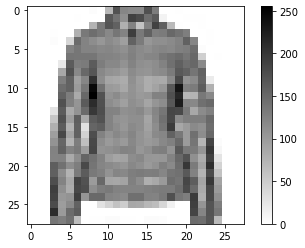

In [98]:
# Take a single image, and remove the color dimension by reshaping
for image, label in test_dataset.take(1):
  break
image = image.numpy().reshape((28,28))

# Plot the image - voila a piece of fashion clothing
plt.figure()
plt.imshow(image, cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

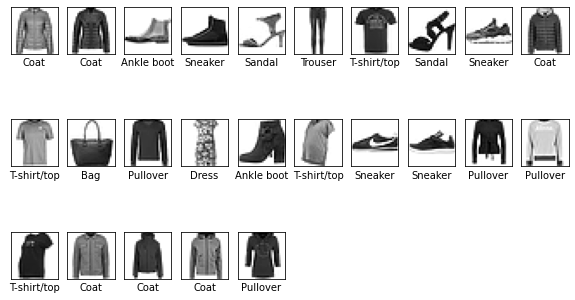

In [99]:
plt.figure(figsize=(10,10))
i = 0
for (image, label) in test_dataset.take(25):
    image = image.numpy().reshape((28,28))
    plt.subplot(5,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image, cmap=plt.cm.binary)
    plt.xlabel(class_names[label])
    i += 1
plt.show()

# Build the Model

In [0]:
model = tf.keras.Sequential([
                             tf.keras.layers.Flatten(input_shape = (28,28,1)),
                             tf.keras.layers.Dense(512, activation = tf.nn.relu),
                             tf.keras.layers.Dense(128, activation = tf.nn.relu),
                             tf.keras.layers.Dense(10, activation = tf.nn.softmax)
])

# compile the model
model.compile(optimizer = 'adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics = ['accuracy'])

# Train the model

In [0]:
Batch_size = 32
train_dataset = train_dataset.cache().repeat().shuffle(num_train_examples).batch(Batch_size)
test_dataset = test_dataset.cache().batch(Batch_size)

In [102]:
model.fit(train_dataset, epochs = 5, steps_per_epoch= math.ceil(num_train_examples/Batch_size))

Epoch 1/5
1875/1875 [==============================] - 6s 3ms/step - loss: 2.4737 - accuracy: 0.7469
Epoch 2/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.5438 - accuracy: 0.8158
Epoch 3/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.4762 - accuracy: 0.8339
Epoch 4/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.4361 - accuracy: 0.8477
Epoch 5/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.4139 - accuracy: 0.8565


In [103]:
test_loss, test_accuracy = model.evaluate(test_dataset, steps = math.ceil(num_test_examples/32))

313/313 [==============================] - 2s 7ms/step - loss: 0.4662 - accuracy: 0.8458


# Make predictions and explore

In [0]:
for test_images, test_labels in test_dataset.take(1):
  test_images = test_images.numpy()
  test_labels = test_labels.numpy()
  predictions = model.predict(test_images)

In [105]:
predictions.shape

(32, 10)

In [106]:
predictions[0]

array([1.1628648e-03, 1.9441695e-05, 6.8714388e-02, 1.3197188e-02,
       8.7144285e-01, 1.5877030e-19, 4.2404518e-02, 1.4199419e-21,
       3.0587367e-03, 1.5874263e-13], dtype=float32)

In [107]:
np.argmax(predictions[0])

4

In [108]:
test_labels[0]

4

In [0]:
# make a graph

def plot_image(i, predictions_array, true_labels, images):
  predictions_array, true_label, img = predictions_array[i], true_labels[i],images[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(img[...,0], cmap = plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color ='blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({}) ".format(class_names[predicted_label],
                                        100*np.max(predictions_array),
                                        class_names[true_label],),
                                        color = color)
  
def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10),  predictions_array, color="#777777")
  plt.ylim([0, 1]) 
  predicted_label = np.argmax(predictions_array)
  
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

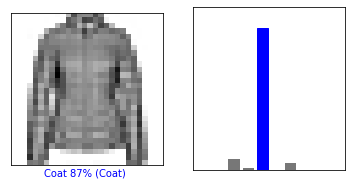

In [110]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)

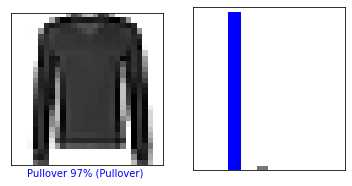

In [111]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)

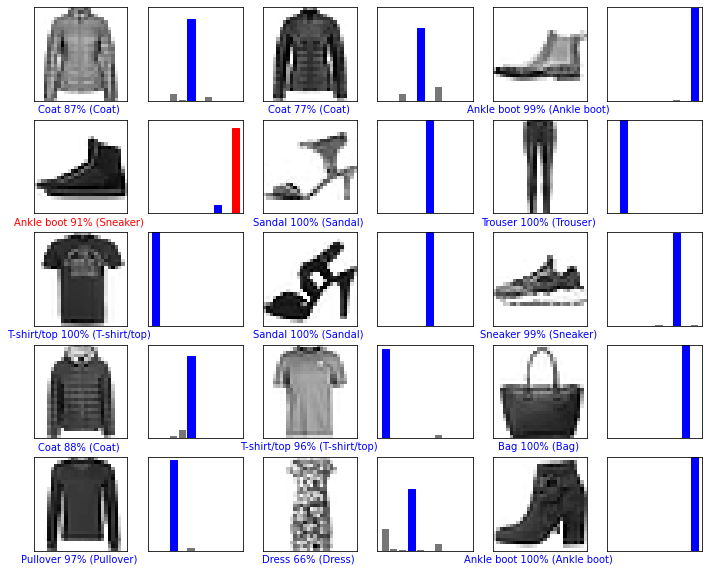

In [112]:
# Plot the first X test images, their predicted label, and the true label
# Color correct predictions in blue, incorrect predictions in red
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions, test_labels)

In [113]:
# Grab an image from the test dataset
img = test_images[0]

print(img.shape)

(28, 28, 1)


In [114]:
# Add the image to a batch where it's the only member.
img = np.array([img])

print(img.shape)

(1, 28, 28, 1)


In [115]:
predictions_single = model.predict(img)

print(predictions_single)

[[1.1628642e-03 1.9441679e-05 6.8714388e-02 1.3197175e-02 8.7144285e-01
  1.5876971e-19 4.2404518e-02 1.4199311e-21 3.0587383e-03 1.5874234e-13]]


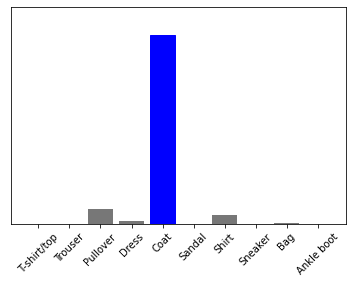

In [116]:
plot_value_array(0, predictions_single, test_labels)
_ = plt.xticks(range(10), class_names, rotation=45)

In [117]:
np.argmax(predictions_single[0])


4